In [1]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

In [21]:
# Make counts
count_dataframe = pd.read_feather('s1-matrices.dir/autorif_jensen.feather').set_index('gene_symbol')
count_dataframe.head()

/Users/denis/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



A1BG  A1BG-AS1  A1CF   A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  AAAS  \
gene_symbol                                                                    
A1BG         1170         1     0     6        0      0       0      0     0   
A1BG-AS1        1         1     0     0        0      0       0      0     0   
A1CF            0         0   128     0        0      0       0      0     0   
A2M             6         0     0  2674        1      1       0      0     0   
A2M-AS1         0         0     0     1        2      0       0      0     0   

             AACS  ...    ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  \
gene_symbol        ...                                                    
A1BG            0  ...       0       0      0     0     0     0       0   
A1BG-AS1        0  ...       0       0      0     0     0     0       0   
A1CF            0  ...       0       0      0     0     0     0       0   
A2M             0  ...       0       0      0     0     0     0       0   
A2M-AS1         0  ...       0       0      0     0     0     0       0   

             ZYG11B  ZYX  ZZEF1  
gene_symbol                      
A1BG              0    0      0  
A1BG-AS1          0    0      0  
A1CF              0    0      0  
A2M               0    0      0  
A2M-AS1           0    0      0  

[5 rows x 18105 columns]

In [22]:
# Get counts
gene_count_dataframe = pd.Series(np.diag(count_dataframe), index=count_dataframe.index, name='counts').to_frame()
gene_count_dataframe.head()

counts
gene_symbol        
A1BG           1170
A1BG-AS1          1
A1CF            128
A2M            2674
A2M-AS1           2

In [4]:
# Read ARCHS4 HDF5
infile = '/Users/denis/Documents/Projects/jupyter-notebook/notebook-generator/database/data/archs4/rawdata.dir/v6/human_matrix.h5'
r = h5py.File(infile, 'r')

# Get matrix data
expr = r['data']['expression'].value
genes = r['meta']['genes'].value.astype(str)

# Submitted genes
genes_idx = [i for i, gene in enumerate(genes) if gene in gene_count_dataframe.index]

In [5]:
archs_matrix = expr[:5000, genes_idx]
archs_matrix_norm = (archs_matrix.T/archs_matrix.sum(axis=1)).T*10**6

In [6]:
# Get mean
mean_dataframe = pd.Series(data=np.mean(archs_matrix_norm, axis=0), index=genes[genes_idx]).rename('average_counts').to_frame()
mean_dataframe.head()

average_counts
A1BG         13.196800
A1CF          7.861049
A2M         285.223333
A2ML1        10.469510
A4GALT        8.473479

In [7]:
biotype_dataframe = pd.read_table('rawdata.dir/gene_biotypes.txt', index_col='Gene name').rename(columns={'Gene type': 'gene_type'})
biotype_dataframe.head()

gene_type
Gene name           
MIR4723        miRNA
RF00019     misc_RNA
RF02116     misc_RNA
MIR6085        miRNA
RNU6-1328P     snRNA

In [23]:
# Merge
print(gene_count_dataframe.shape)
print(mean_dataframe.shape)
print(biotype_dataframe.shape)
plot_dataframe = gene_count_dataframe.merge(mean_dataframe, left_index=True, right_index=True).merge(biotype_dataframe, left_index=True, right_index=True)
plot_dataframe['pseudogene'] = ['pseudogene' in x for x in plot_dataframe['gene_type']]
print(plot_dataframe.shape)
plot_dataframe.head()

(18105, 1)
(16668, 1)
(64914, 1)
(18574, 4)


counts  average_counts       gene_type  pseudogene
A1BG      1170       13.196800  protein_coding       False
A1CF       128        7.861049  protein_coding       False
A2M       2674      285.223333  protein_coding       False
A2ML1       23       10.469510  protein_coding       False
A4GALT     481        8.473479  protein_coding       False

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



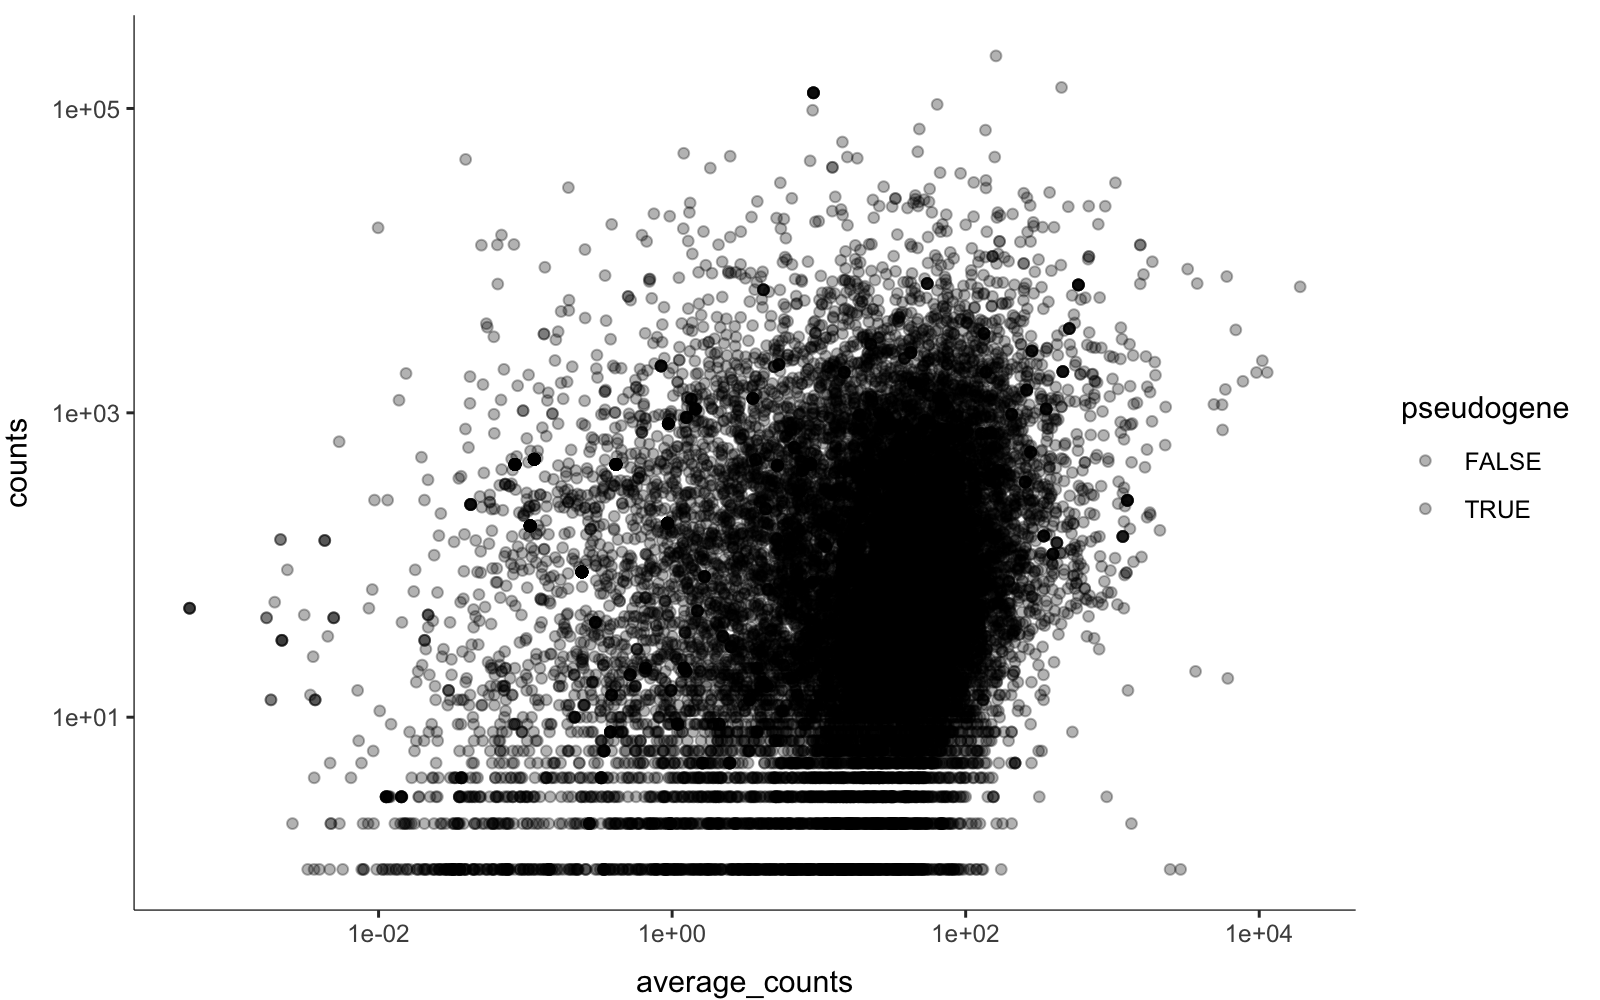

In [24]:
%%R -i plot_dataframe -h 1000 -w 1600 -r 200
#ticks <- seq()
ggplot(plot_dataframe, aes(x=average_counts, y=counts, fill=pseudogene)) +
geom_point(alpha=0.3) +
#facet_wrap(~, scales='free') +
#coord_flip() +
#scale_fill_manual(values=c('', '')) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
scale_x_log10() +
scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
#geom_abline(intercept=0, slope=1) +
#xlab('') +
#ylab('') +
#labs(title = '', x = '', y = '', color = '', fill='') +
#guides(fill=FALSE) +
theme_classic() +
theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))